pip install pandas matplotlib sklearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
!jq . "COVID-19/dati-json/dpc-covid19-ita-province.json" > "dpc-covid19-ita-province-nobom.json"
!jq . "COVID-19/dati-json/dpc-covid19-ita-regioni.json" > "dpc-covid19-ita-regioni-nobom.json"
!jq . "COVID-19/dati-json/dpc-covid19-ita-andamento-nazionale.json" > "dpc-covid19-ita-andamento-nazionale-nobom.json"

In [3]:
ita_province = pd.read_json('dpc-covid19-ita-province-nobom.json')
ita_regioni = pd.read_json('dpc-covid19-ita-regioni-nobom.json')
ita_andamento_nazionale = pd.read_json('dpc-covid19-ita-andamento-nazionale-nobom.json')

In [4]:
data = ita_regioni.set_index(['denominazione_regione', 'data']).sort_index().reset_index()

data['data'] = pd.to_datetime(data['data'])
del data['long'], data['lat'], data['stato'], data['codice_regione'], data['nuovi_attualmente_positivi']
del data['totale_attualmente_positivi'], data['totale_ospedalizzati']

In [5]:
def carica_province():
    x = ita_province[['data', 'denominazione_provincia', 'totale_casi']].copy().sort_values(['denominazione_provincia', 'data'])
    x['data'] = pd.to_datetime(x['data'])
    x['luogo'] = x['denominazione_provincia']
    x['nuovi_casi'] = x.groupby('luogo').totale_casi.diff()
    x['totale_casi_prec'] = x.groupby('luogo').totale_casi.shift()
    x['crescita'] = x['nuovi_casi'] / x['totale_casi_prec']

    x = x[x['luogo'] != 'In fase di definizione/aggiornamento']
    
    x = x.replace([np.inf, -np.inf], np.nan).dropna()
    
    return x

In [6]:
def carica_regioni():
    x = ita_regioni[['data', 'denominazione_regione', 'totale_casi']].copy().sort_values(['denominazione_regione', 'data'])
    x['data'] = pd.to_datetime(x['data'])
    x['luogo'] = x['denominazione_regione']
    x['nuovi_casi'] = x.groupby('luogo').totale_casi.diff()
    x['totale_casi_prec'] = x.groupby('luogo').totale_casi.shift()
    x['crescita'] = x['nuovi_casi'] / x['totale_casi_prec']

    x = x[x['luogo'] != 'In fase di definizione/aggiornamento']
    
    x = x.replace([np.inf, -np.inf], np.nan).dropna()
    
    return x

In [7]:
def carica_andamento_nazionale():
    x = ita_andamento_nazionale[['data', 'totale_casi']].copy().sort_values('data')
    x['data'] = pd.to_datetime(x['data'])
    #x['giorno'] = x.groupby('data').ngroup()
    x['nuovi_casi'] = x.totale_casi.diff()
    x['totale_casi_prec'] = x.totale_casi.shift()
    x['crescita'] = x['nuovi_casi'] / x['totale_casi_prec']
    x['luogo'] = 'Italia'

    x = x.replace([np.inf, -np.inf], np.nan).dropna()
    
    return x

In [8]:
dati_province = carica_province()
dati_regioni = carica_regioni()
dati_andamento_nazionale = carica_andamento_nazionale()

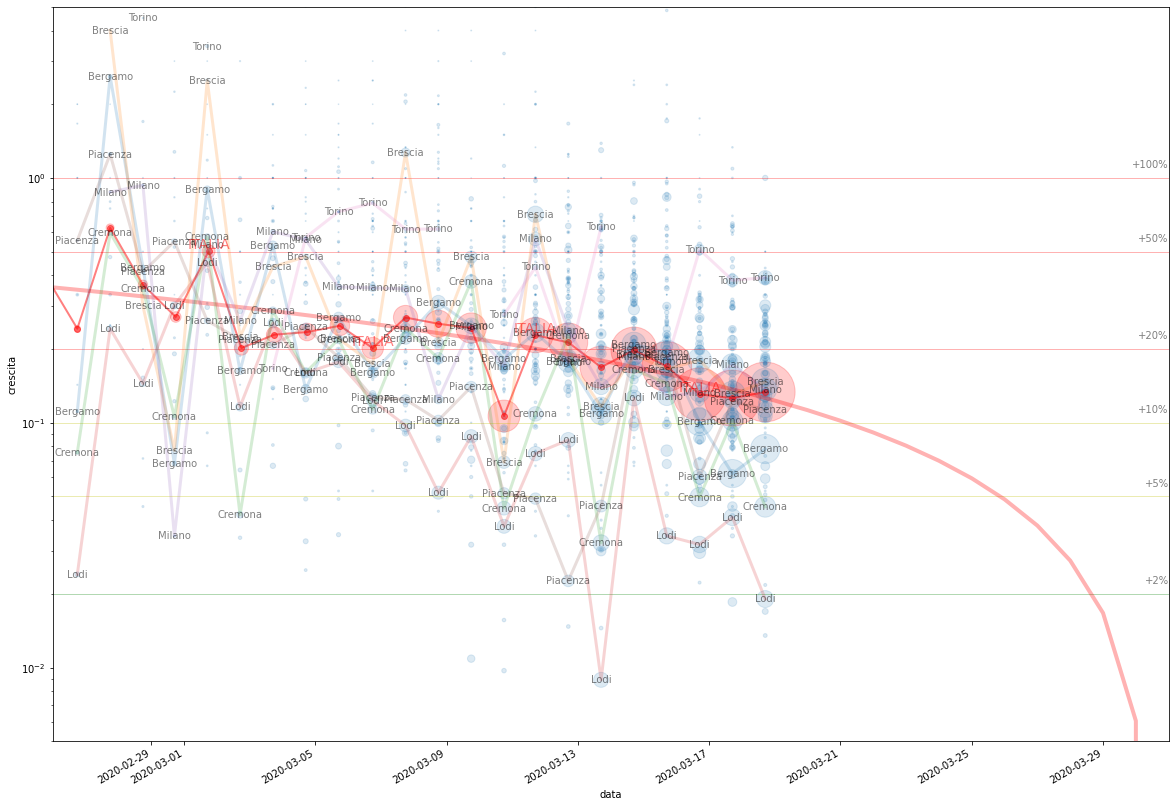

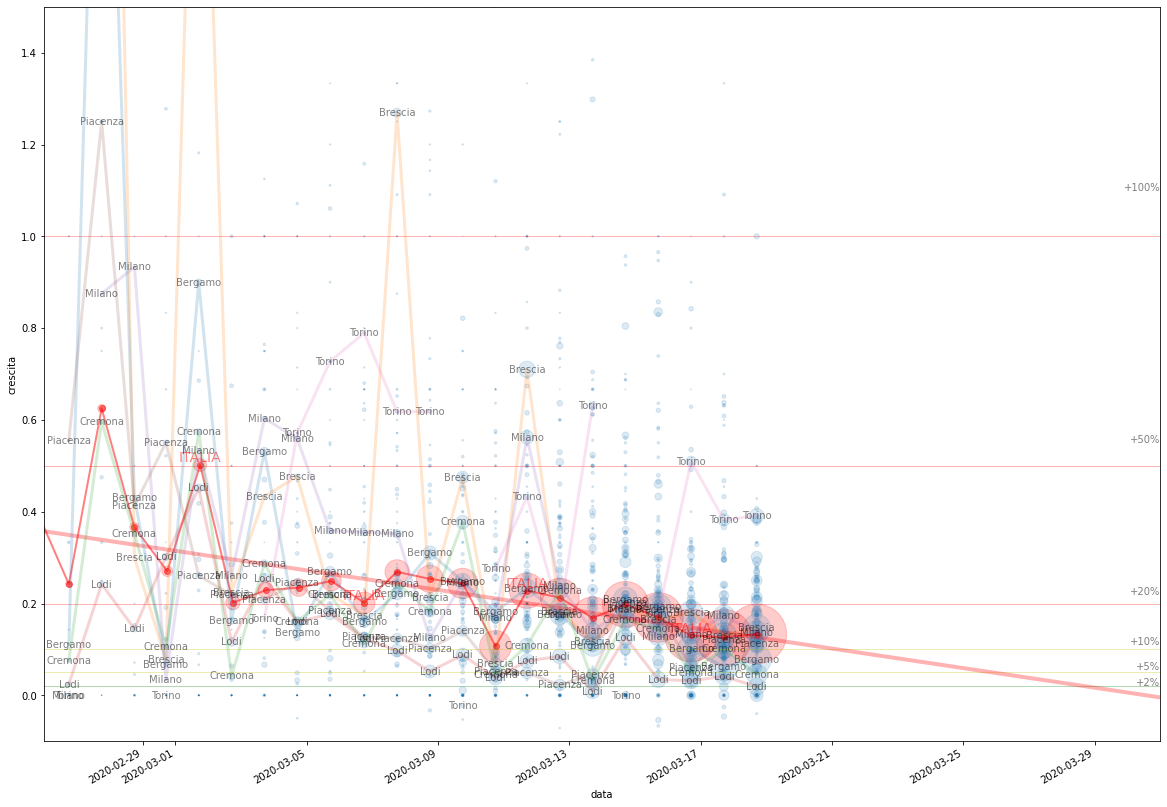

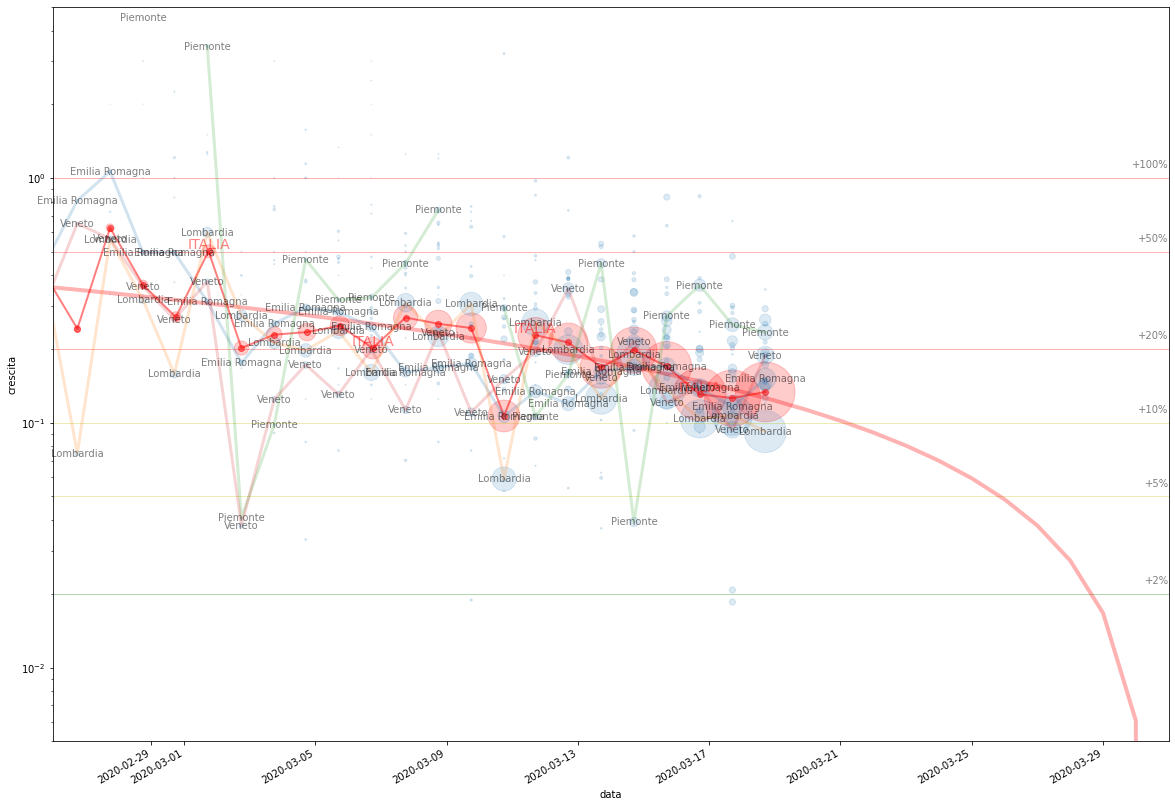

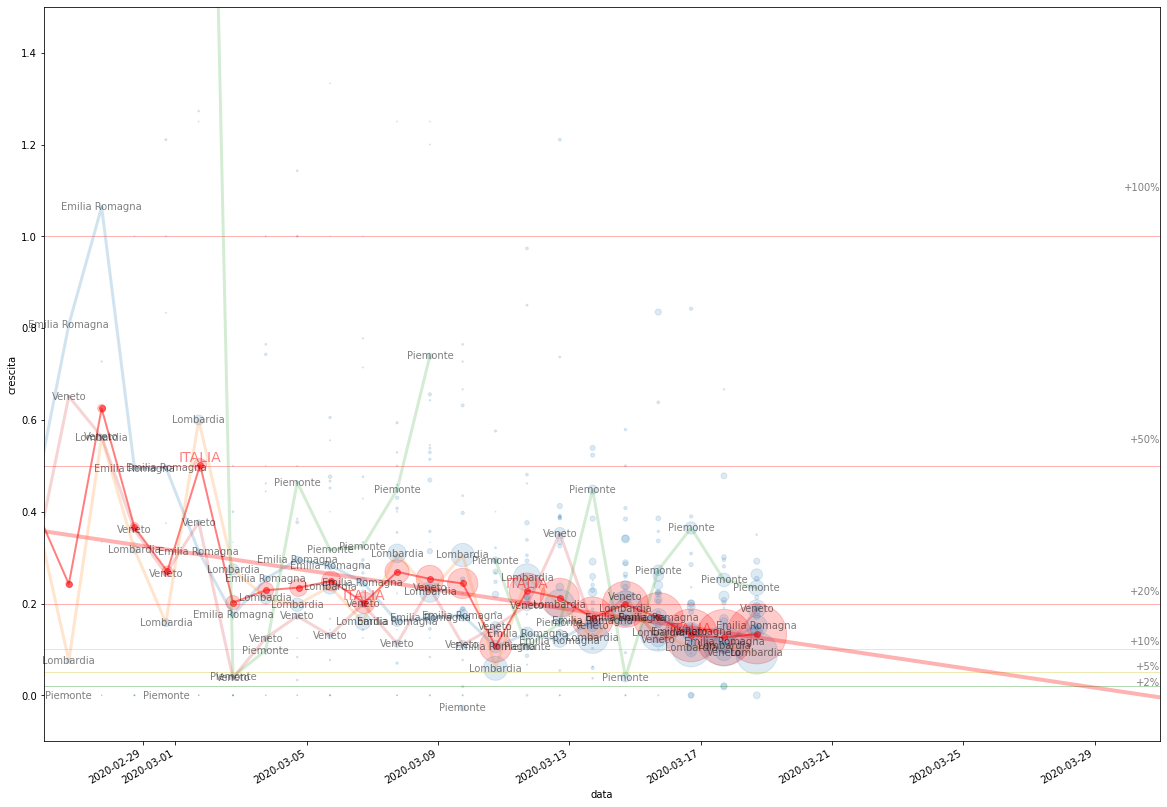

In [9]:
xlim_date = [pd.to_datetime('2020-02-26'), pd.to_datetime('2020-03-31')]
xlim = [d.to_datetime64() for d in xlim_date]

for risoluzione_nome, dati, scatter_size, min_casi in [
    ('province', dati_province, 0.2, 1000),
    ('regioni', dati_regioni, 0.1, 2000),
]:
    for logy in [True, False]:
        if logy:
            ylim = (0.005, 5)
        else:
            ylim = (-0.1, 1.5)

        italia = dati_andamento_nazionale
        italia['crescita'] = italia['nuovi_casi'] / italia['totale_casi_prec']

        italia.plot.scatter(
            'data', 
            'crescita', 
            s=0.1 * italia['totale_casi'], 
            color='r', 
            alpha=0.2,
            logy=logy, 
            ylim=ylim, 
            figsize=(20, 15),
        )
        ax = plt.gca()

        italia.set_index('data')['crescita'].plot(style='o-r', alpha=0.5, linewidth=2)

        dati.plot.scatter(
            'data', 'crescita', 
            s=scatter_size*dati['totale_casi'], 
            alpha=0.15,
            ax=ax, 
        )

        for coeff, style in [
            [1.00, 'r'],
            [0.50, 'r'],
            [0.20, 'r'],
            [0.10, 'y'],
            [0.05, 'y'],
            [0.02, 'g'],
        ]:
            ax.plot(xlim, [coeff, coeff], style, linewidth=1, alpha=0.3)
            ax.annotate(f"+{coeff * 100:.0f}%", (xlim[1], coeff * 1.1), alpha=0.5, ha='right')

        train = italia[['data', 'crescita', 'totale_casi']].copy()
        train['secondi'] = (train['data'] - xlim_date[0]).dt.total_seconds()

        regr = LinearRegression()
        regr.fit(
            train['secondi'].values.reshape(-1, 1), 
            train['crescita'].values.reshape(-1, 1), 
            train['totale_casi'].values,
        )

        dr = pd.date_range(*xlim_date).to_series()

        pred_crescita = pd.Series(regr.predict((dr - xlim_date[0]).dt.total_seconds().values.reshape(-1, 1))[:,0], index=dr)
        pred_crescita.plot(c='r', linewidth=4, alpha=0.3)

        for provincia, d in dati.groupby('luogo'):
            if not d['totale_casi'].iloc[-1] > min_casi:
                continue

            d = d.copy().set_index('data', drop=False)
            d['crescita'].where(d['crescita'] > 0).plot(
                xlim=xlim,
                ylim=ylim,
                alpha=0.2,
                linewidth=3,
        #         c='k',
            )

            x = d
            x = x[x['data'] > xlim[0]]
            #x = x[x['totale_casi'] > 300]
            x = x[ylim[0] < x['crescita']]
            x = x[x['crescita'] < ylim[1]]
            #x = x[(x['crescita'] == x['crescita'].max()) | (x['crescita'] == x['crescita'].min())]

            for y in x.iloc:
                ax.annotate(provincia, (y['data'].to_datetime64(), y['crescita']), c='k', va='center', ha='center', alpha=0.5)

        for y in italia.iloc[::5].iloc:
            ax.annotate('ITALIA', (y['data'].to_datetime64(), y['crescita']), c='r', va='bottom', ha='center', alpha=0.5, fontsize=14)

        if logy:
            logy_name = 'log'
        else:
            logy_name = 'lin'
        plt.savefig(f"{risoluzione_nome}-{logy_name}-{dati['data'].max().to_pydatetime().date().isoformat()}.png")

In [ ]:
groups = list(dati_province[dati_province['data'] > '2020-03-10'].groupby('data'))
groups.reverse()
fig, axes = plt.subplots(len(groups), 1, figsize=(20, 20 * len(groups)), sharey=True)

ylim = [0.01, 2]

for (d, g), ax in zip(groups, axes):
    ax.set_title(f"{d}")

    data = g.set_index('denominazione_provincia')

    ax.set_yscale('log')
    ax.set_xscale('log')
    data.plot.scatter('totale_casi', 'crescita', marker='+', xlim=(1e1, 1e4), ylim=ylim, loglog=True, ax=ax)

    for casi in [1e2, 1e3]:
        ax.plot([casi, casi], ylim, 'k', linewidth=1, alpha=0.2)

    for coeff, style in [
        [1.00, 'r'],
        [0.50, 'r'],
        [0.20, 'r'],
        [0.10, 'y'],
        [0.05, 'y'],
        [0.02, 'g'],
    ]:
        ax.plot([1, 1e5], [coeff, coeff], style, linewidth=1, alpha=0.5)
        ax.annotate(f"+{coeff * 100:.0f}%", (1e4, coeff * 1.1), alpha=0.5, ha='right')

    for provincia in data.index:
        x, y = data.totale_casi[provincia], data.crescita[provincia]

        if x >= 20 and y > 0 and data.crescita[provincia] > 0.01:
            ax.annotate(
                f"{provincia}\n{int(data.totale_casi_prec[provincia])}/{data.totale_casi[provincia]} (+{data.crescita[provincia]*100:.1f}%)",
                (x, y * 1.05),
                alpha=0.4, rotation=0, rotation_mode='anchor', va='bottom', ha='center', ma='center',
            )